# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [7]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [8]:
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # sklearn 내 confusion matrix 계산 함수
import matplotlib.pyplot as plt # 시각화를 위한 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈

In [9]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

# 이미지 탐색

In [82]:
import pandas as pd

# CSV 파일 로드
train = pd.read_csv('/data/ephemeral/home/datasets_fin/train.csv')
meta = pd.read_csv('/data/ephemeral/home/datasets_fin/meta.csv')

train_meta = pd.merge(train, meta, on='target', how='inner')
train_meta



,ID,target,class_name,class_name_kr
0,002f99746285dfdd.jpg,16,vehicle_registration_plate,자동차번호판
1,00b2f44967580c74.jpg,16,vehicle_registration_plate,자동차번호판
2,00f59b12e9e08f29.jpg,16,vehicle_registration_plate,자동차번호판
3,04d106668176a2e6.jpg,16,vehicle_registration_plate,자동차번호판
4,05c521f2659c0711.jpg,16,vehicle_registration_plate,자동차번호판
...,...,...,...,...
1565,efb9805cc6106c48.jpg,6,medical_bill_receipts,외래진료비계산서영수증
1566,f230a7ad534c49a6.jpg,6,medical_bill_receipts,외래진료비계산서영수증
1567,fa6d6811b624d725.jpg,6,medical_bill_receipts,외래진료비계산서영수증
1568,fc86eb71611c9854.jpg,6,medical_bill_receipts,외래진료비계산서영수증


In [51]:
meta

,target,class_name
0,0,account_number
1,1,application_for_payment_of_pregnancy_medical_e...
2,2,car_dashboard
3,3,confirmation_of_admission_and_discharge
4,4,diagnosis
5,5,driver_lisence
6,6,medical_bill_receipts
7,7,medical_outpatient_certificate
8,8,national_id_card
9,9,passport


In [91]:
# 이미지 파일 리스트
# target이 0인 ID 추출
#target_zero_ids = train_meta[train_meta['target'] == 16]['ID'].tolist()
target_zero_ids =train[train['ID'] == '0583254a73b48ece.jpg']['ID'].tolist()
# 디렉토리 설정
dataset_dir = '/data/ephemeral/home/datasets_fin/train/'

# .jpg 파일만 리스트에 포함, target이 0인 ID에 해당하는 파일만 포함
img_file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg') and f.split(',')[0] in target_zero_ids]

# 파일 리스트 정렬
img_file_list.sort()

len(img_file_list)

1

<Figure size 1600x1000 with 0 Axes>

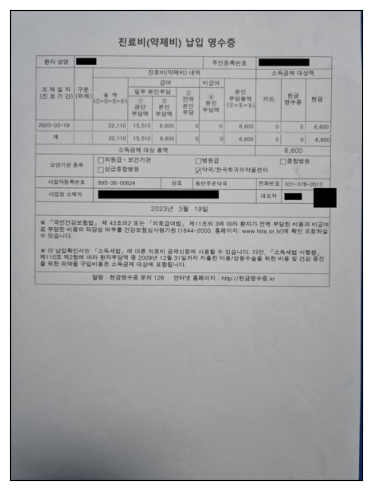

In [92]:
# 이미지 시각화
plt.figure(figsize=(16,10))
img_file_list = img_file_list[:5]  # 리스트를 15개로 제한

# 전체 이미지 개수에 따라 subplot의 크기 조정
rows = len(img_file_list) // 3 + (len(img_file_list) % 3 > 0)  # 3열 기준으로 행 계산
cols = 3  # 항상 3열로 표시

# figsize 조정: 각 이미지에 충분한 공간을 할당
plt.figure(figsize=(cols * 5, rows * 5))  # 각 이미지당 가로 5인치, 세로 5인치 할당

for i, f in enumerate(img_file_list):
    plt.subplot(rows, cols, i + 1)  # rows x cols 그리드에서 i+1 번째 위치에 subplot 생성
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = Image.open(os.path.join(dataset_dir, f))  # 파일 경로 결합 오류 수정
    plt.imshow(img)

plt.tight_layout()  # subplot 간의 여백을 자동으로 조정
plt.show()

In [ ]:
# 레이블 수정
train['target'][train['ID'] == '45f0d2dfc7e47c03.jpg'] = 7 # 기존 3
train['target'][train['ID'] == 'aec62dced7af97cd.jpg'] = 14 # 3
train['target'][train['ID'] == '8646f2c3280a4f49.jpg'] = 3 # 7
train['target'][train['ID'] == '1ec14a14bbe633db.jpg'] = 7 # 14
train['target'][train['ID'] == '7100c5c67aecadc5.jpg'] = 7 # 3
train['target'][train['ID'] == 'c5182ab809478f12.jpg'] = 14 # 4
train['target'][train['ID'] == '38d1796b6ad99ddd.jpg'] = 10 # 11
train['target'][train['ID'] == '0583254a73b48ece.jpg'] = 10 # 11